Import library yang diperlukan, untuk kasus ini saya menggunakan google colab

In [1]:
from tensorflow import keras
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Read data dan melakukan inverse data

In [2]:
data = pd.read_csv('USD_INR.csv', index_col='Date')
data.index = pd.to_datetime(data.index)
data = data.iloc[::-1]
print(data)

             Price    Open    High     Low  Change %
Date                                                
1980-01-02   8.000   8.000   8.000   8.000      0.00
1980-01-03   7.950   7.950   7.950   7.950     -0.63
1980-01-04   8.050   8.050   8.050   8.050      1.26
1980-01-07   8.050   8.050   8.050   8.050      0.00
1980-01-08   8.050   8.050   8.050   8.050      0.00
...            ...     ...     ...     ...       ...
2017-08-04  63.675  63.670  63.786  63.572     -0.05
2017-08-07  63.840  63.710  63.865  63.648      0.26
2017-08-08  63.692  63.750  63.785  63.615     -0.23
2017-08-09  63.860  63.780  63.860  63.710      0.26
2017-08-10  64.165  63.898  64.175  63.855      0.48

[9697 rows x 5 columns]


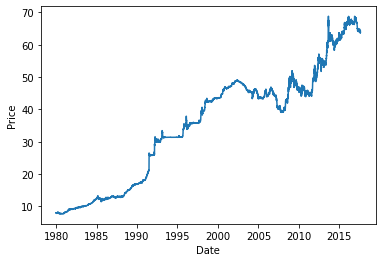

In [3]:
plt.plot(data['Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Mengambil data 'Price' kemudian Split data menjadi 80% training dan 20% testing

In [4]:
data = data.filter(['Price'])
dataset = data.values
training_data = math.ceil(len(dataset) * 0.8)

training_data

7758

Melakukan scaling dengan MinMaxScaler

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00523517],
       [0.00441718],
       [0.00605317],
       ...,
       [0.91635174],
       [0.9191002 ],
       [0.92408998]])

Melakukan windowing dengan ukuran window 50

In [6]:
train_data = scaled_data[0:training_data,:]
x_train = []
y_train = []
for i in range(50, len(train_data)):
  x_train.append(train_data[i-50:i, 0])
  y_train.append(train_data[i, 0])
  if i<51:
    print(x_train)
    print(y_train)

[array([0.00523517, 0.00441718, 0.00605317, 0.00605317, 0.00605317,
       0.00523517, 0.00523517, 0.00572597, 0.00572597, 0.00359918,
       0.00359918, 0.00458078, 0.00278119, 0.00408998, 0.00490798,
       0.00523517, 0.00523517, 0.00523517, 0.00523517, 0.00523517,
       0.00523517, 0.00621677, 0.00588957, 0.00588957, 0.00523517,
       0.00458078, 0.00392638, 0.00278119, 0.00359918, 0.00359918,
       0.00359918, 0.00392638, 0.00490798, 0.00523517, 0.00523517,
       0.00523517, 0.00605317, 0.00605317, 0.00556237, 0.00621677,
       0.00621677, 0.00654397, 0.00654397, 0.00687117, 0.00736196,
       0.00736196, 0.00736196, 0.00768916, 0.00736196, 0.00736196])]
[0.008016359918200405]


In [7]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(7708, 50, 1)

Membuat model dan fit model

In [8]:
model = keras.Sequential()
model.add(keras.layers.LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.LSTM(50, return_sequences=False))
model.add(keras.layers.Dense(25))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))

In [9]:
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

7708/7708 [==============================] - 114s 14ms/step - loss: 2.5260e-04


In [10]:
test_data = scaled_data[training_data - 50:, :]
x_test =[]
y_test = dataset[training_data:, :]
for i in range(50, len(test_data)):
    x_test.append(test_data[i-50:i, 0])

In [11]:
x_test = np.array(x_test)

In [12]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Membuat prediksi

In [13]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

Menghitung Root Mean Square Error

In [14]:
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.2650296658559703

Melakukan plot

c:\users\radiadus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


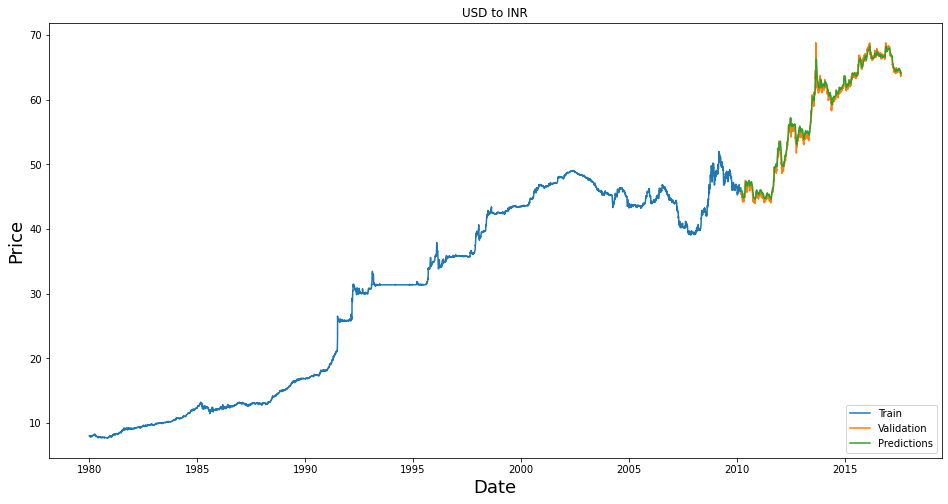

In [15]:
train = data[:training_data]
valid = data[training_data:]

plt.figure(figsize=(16,8))
valid['Predictions'] = predictions
plt.title("USD to INR")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.plot(train['Price'])
plt.plot(valid[['Price', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()

In [16]:
valid

,Price,Predictions
Date,,
2010-03-08,45.535,46.340576
2010-03-09,45.590,46.257526
2010-03-10,45.420,46.198402
2010-03-11,45.515,46.131783
2010-03-12,45.465,46.086330
...,...,...
2017-08-04,63.675,64.205154
2017-08-07,63.840,64.126923
2017-08-08,63.692,64.086853
